<h1>AI2 - PROJECT4 - FOUKANELIS CHRISTOS GEORGIOS - 1115201900204<h1>
BERT FINE TUNING FOR IMDB SENTIMENT ANALYSIS

IMPORTS

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

import nltk
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords')
import re

# specify GPU
device = torch.device("cuda")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INITIALIZATIONS

In [2]:
torch.cuda.empty_cache()
from GPUtil import showUtilization as gpu_usage
gpu_usage()
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)
print(torch.cuda.memory_allocated(device))

| ID | GPU | MEM |
------------------
|  0 |  1% |  4% |
0


PREPROCESSING

In [3]:
cachedStopWords = stopwords.words("english")

def remove_links(x):
    return re.sub(r"http\S+", "", x)

def remove_punctuation(x):
    return re.sub(r'[^\w\s]', '', x)

def lowercase(x):
    return x.lower()

def remove_stopwords(x):
    return ' '.join([word for word in x.split() if word not in cachedStopWords])

def remove_html(x):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', x)

def sentiment_label(x):
    if x >= 7.0:
        return 1
    elif x <= 4.0:
        return 0
    
def word_count(x):
    return len(x.split(' '))

In [4]:
df = pd.read_csv('imdb-reviews.csv',sep = '\t', engine = 'python')
df.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,This movie is really genuine and random. It's ...


DATA CLEANING

In [5]:
# clean the data
df['review'] = df['review'].apply(remove_links)
df['review'] = df['review'].apply(lowercase)
df['review'] = df['review'].apply(remove_punctuation)
df['review'] = df['review'].apply(remove_stopwords)
df['review'] = df['review'].apply(remove_html)
df['sentiment'] = df['rating'].apply(sentiment_label)

In [6]:
df['text'] = df['review']
df['label'] =df['sentiment']

In [7]:
df.head()

,url,rating,review,sentiment,text,label
0,http://www.imdb.com/title/tt0120623/usercomments,10.0,thought quiet good movie fun watch liked best ...,1,thought quiet good movie fun watch liked best ...,1
1,http://www.imdb.com/title/tt0043117/usercomments,9.0,wagon master unique film amongst john fords wo...,1,wagon master unique film amongst john fords wo...,1
2,http://www.imdb.com/title/tt0043117/usercomments,10.0,film near perfect film john ford made film mag...,1,film near perfect film john ford made film mag...,1
3,http://www.imdb.com/title/tt0835204/usercomments,4.0,gave 4 stars lot interesting themes many alrea...,0,gave 4 stars lot interesting themes many alrea...,0
4,http://www.imdb.com/title/tt0499603/usercomments,10.0,movie really genuine random really hard find m...,1,movie really genuine random really hard find m...,1


DATA SPLIT

In [8]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

BERT EMBEDDINGS

In [9]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot: >

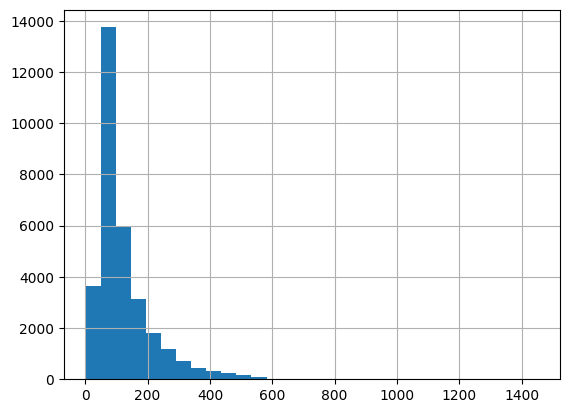

In [10]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [11]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\chris\anaconda3\envs\ai\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TRAIN AND VALIDATION DATA

In [12]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [13]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [14]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

MODEL

In [15]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.2)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,384)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(384,1)

        #sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask).to_tuple()
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply sigmoid activation
        x = self.sigmoid(x)
        return x

In [16]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

MODEL PARAMETERS

In [17]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 0.001)          # learning rate

C:\Users\chris\anaconda3\envs\ai\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [53]:
# define the loss function
cross_entropy  = nn.BCELoss() #weight=weights

# number of training epochs
epochs = 20

TRAINING AND EVALUATION OF MODEL

In [54]:
# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)
        
        preds = torch.flatten(preds)

        preds = preds.type(torch.DoubleTensor)
        labels = labels.type(torch.DoubleTensor)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
  
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [55]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
        # model predictions
        preds = model(sent_id, mask)
        preds = torch.flatten(preds)
        
        preds = preds.type(torch.DoubleTensor)
        labels = labels.type(torch.DoubleTensor)

        # compute the validation loss between actual and predicted values
        loss = cross_entropy(preds,labels)

        total_loss = total_loss + loss.item()

        preds = preds.detach().cpu().numpy()

        total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [56]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    493.
  Batch   100  of    493.
  Batch   150  of    493.
  Batch   200  of    493.
  Batch   250  of    493.
  Batch   300  of    493.
  Batch   350  of    493.
  Batch   400  of    493.
  Batch   450  of    493.

Evaluating...
  Batch    50  of    106.
  Batch   100  of    106.

Training Loss: 0.609
Validation Loss: 0.005

 Epoch 2 / 20
  Batch    50  of    493.
  Batch   100  of    493.
  Batch   150  of    493.
  Batch   200  of    493.
  Batch   250  of    493.
  Batch   300  of    493.
  Batch   350  of    493.
  Batch   400  of    493.
  Batch   450  of    493.

Evaluating...
  Batch    50  of    106.
  Batch   100  of    106.

Training Loss: 0.609
Validation Loss: 0.005

 Epoch 3 / 20
  Batch    50  of    493.
  Batch   100  of    493.
  Batch   150  of    493.
  Batch   200  of    493.
  Batch   250  of    493.
  Batch   300  of    493.
  Batch   350  of    493.
  Batch   400  of    493.
  Batch   450  of    493.

Evaluating...
  Batch    50 

TESTING PREFORMANCE OF MODEL

In [57]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [58]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = torch.round(preds)
    preds = preds.detach().cpu().numpy()

In [59]:
#preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.66      0.76      0.71      3375
           1       0.72      0.61      0.66      3377

    accuracy                           0.69      6752
   macro avg       0.69      0.69      0.69      6752
weighted avg       0.69      0.69      0.69      6752



In [ ]:
##########################TESTING-INSERT CSV FILE HERE###########################################################

# insert csv path here
test_csv_path = ''
test_df = pd.read_csv(test_csv_path, sep = '\t', engine = 'python')
# clean the data
test_df['review'] = test_df['review'].apply(remove_links)
test_df['review'] = test_df['review'].apply(lowercase)
test_df['review'] = test_df['review'].apply(remove_punctuation)
test_df['review'] = test_df['review'].apply(remove_stopwords)
test_df['review'] = test_df['review'].apply(remove_html)
test_df['sentiment'] = test_df['rating'].apply(sentiment_label)
test_df['text'] = test_df['review']
test_df['label'] = test_df['sentiment']


# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_df['text'].tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_df['labels'].tolist())

#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = torch.round(preds)
    preds = preds.detach().cpu().numpy()
print(classification_report(test_y, preds))
###################################################################################################################